# Scatter Plots

## Load Libraries

In [1]:
from obspy import UTCDateTime
from scipy.signal import welch
from tqdm import tqdm
from pathlib import Path

import os, sys
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# from andbro__store_as_pickle import __store_as_pickle

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [3]:
## ---------------------------------------

name0 = "FFBI"

name1 = "ROMY_U"
name2 = "ROMY_V"
name3 = "ROMY_Z"


# t1 ,t2 = "2023-09-23", "2023-10-23"

In [4]:
# ## ---------------------------------------

config = {}

## specify paths
config['path_to_figs'] = data_path+f"LNM2/figures/scatter/"

config['path_to_data'] = data_path+f"LNM2/data/"

config['path_to_data'] = data_path+f"LNM2/data/"

## Methods

In [5]:
dat1 = pd.read_pickle(config['path_to_data']+name0+".pkl")
dat2 = pd.read_pickle(config['path_to_data']+name2+".pkl")

In [6]:
def __get_octave_bands(fmin, fmax, fband_type="octave", plot=False):

    """
    Computing octave / one-third-octave bands

    Arguments:
        - fmin:    (float) minimum center frequency
        - fmax:    (float) maximum center frequency
        - fband_type:    [octave] / one-third-octave
        - plot:    (bool) show frequency bands

    Example:

    >>> flower, fupper, fcenter = __get_octave_bands(f_min, f_max, fband_type="octave", plot=False)

    """

    import matplotlib.pyplot as plt
    from numpy import sqrt, array
    from acoustics import bands

    f_lower, f_upper, f_centers = [], [], []

    if fband_type == "octave":
        f_centers = bands.octave(fmin, fmax)
        f_lower = bands.octave_low(fmin, fmax)
        f_upper = bands.octave_high(fmin, fmax)

    if fband_type == "one-third-octave":
        f_centers = bands.third(fmin, fmax)
        f_lower = bands.third_low(fmin, fmax)
        f_upper = bands.third_high(fmin, fmax)

    if plot:
        plt.figure()
        for fl, fc, fu in zip(f_lower, f_centers, f_upper):
            plt.axvline(fu, color="r")
            plt.axvline(fl, color="r")
            plt.axvline(fc)
            plt.axvline(fmin, color="g")
            plt.axvline(fmax, color="g")
            plt.xscale("log")
        plt.show()

    return array(f_lower), array(f_upper), array(f_centers)

In [7]:
def __quantile_regression(x, y, quantiles=[0.05, 0.5, 0.95]):


    from sklearn.utils.fixes import parse_version, sp_version
    from sklearn.linear_model import QuantileRegressor
    from numpy import newaxis, zeros_like, bool_, logical_or, array

    # This is line is to avoid incompatibility if older SciPy version.
    # You should use `solver="highs"` with recent version of SciPy.
    solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"

    predictions = {}

    x = array(x)
    X = x[:, newaxis]

    out_bounds_predictions = zeros_like(y, dtype=bool_)

    for quantile in quantiles:
        qr = QuantileRegressor(quantile=quantile, alpha=0, solver=solver)
        y_pred = qr.fit(X, y).predict(X)
        predictions[quantile] = y_pred

        if quantile == min(quantiles):
            out_bounds_predictions = logical_or(
                out_bounds_predictions, y_pred >= y
            )
        elif quantile == max(quantiles):
            out_bounds_predictions = logical_or(
                out_bounds_predictions, y_pred <= y
            )

    print(qr.score(X, y))
    return predictions

In [8]:
f_lower, f_upper, f_center = __get_octave_bands(1e-3, 1e0, fband_type="one-third-octave", plot=False)

N_bands = dat1.shape[1] - 1

bands = dat1.keys()[1:]

for _n, band in enumerate(bands):

    if not _n == 10:
        continue

    _dat1 = dat1.loc[:, ["dates", band]]
    _dat2 = dat2.loc[:, ["dates", band]]

    _df = pd.merge(left=_dat1, right=_dat2, how="inner", on="dates")

    _df.dropna(inplace=True)

    _df = _df[_df.iloc[:, 1] < 1e-15]
    _df = _df.reset_index(drop=True)


    xx = np.log10(_df.iloc[:, 1])
    yy = np.log10(_df.iloc[:, 2])

    try:
        pre = __quantile_regression(xx, yy, quantiles=[0.1, 0.5, 0.9])

    except:
        continue

    if not _df.empty:

        fig = plt.figure()

        # ys = powerfit(xx, pre, xx)
        # plt.plot(xx, ys, color="tab:green", ls="--")

        # plt.scatter(_df[f'{band}_x'], _df[f'{band}_y'], s=15, edgecolors="black", lw=0.5, zorder=2)
        plt.scatter(10**xx, 10**yy, s=15, edgecolors="black", lw=0.5, zorder=2)

        plt.plot(10**xx, 10**pre[0.9], color="k", zorder=1, ls=":")

        plt.xscale("log")
        plt.yscale("log")

        plt.title(f"{name1.replace('_','-')} & {name2.replace('_','-')} | fc = {float(_df.keys()[1][:-2])*1e3} mHz")
        plt.ylabel(r"PSD (hPa$^2$ /Hz)")
        plt.xlabel(r"PSD (rad$^2$ /s$^2$ /Hz)")
        plt.grid(zorder=0, alpha=0.5)

        plt.ylim(1e-7, 1e1)
        plt.xlim(1e-23, 1e-15)

        plt.show();

        fig.savefig(config['path_to_figs']+f"{name1}/{str(_n).rjust(3, '0')}_{name1}_{name2}_{band}Hz.png", format="png", dpi=200, bbox_inches='tight');

## Plot all 

In [9]:
dat0 = pd.read_pickle(config['path_to_data']+name0+".pkl")

dat1 = pd.read_pickle(config['path_to_data']+name1+".pkl")
dat2 = pd.read_pickle(config['path_to_data']+name2+".pkl")
dat3 = pd.read_pickle(config['path_to_data']+name3+".pkl")


coh1 = pd.read_pickle(config['path_to_data']+name1+"_coherence.pkl")
coh2 = pd.read_pickle(config['path_to_data']+name2+"_coherence.pkl")
coh3 = pd.read_pickle(config['path_to_data']+name3+"_coherence.pkl")


In [10]:
coh1

dates  0.001   0.00125    0.0016     0.002    0.0025   0.00315  \
0    20230923_00    NaN  0.665512  0.158939  0.473925  0.885911  0.569899   
1    20230923_01    NaN  0.767978  0.726119  0.023762  0.052953  0.164151   
2    20230923_02    NaN  0.716990  0.795413  0.140065  0.690955  0.437274   
3    20230923_03    NaN  0.609181  0.997596  0.989365  0.316128  0.911175   
4    20230923_04    NaN  0.799373  0.249429  0.571556  0.976144  0.531958   
..           ...    ...       ...       ...       ...       ...       ...   
739  20231023_19    NaN  0.898351  0.712816  0.762316  0.947113  0.596885   
740  20231023_20    NaN  0.481116  0.794389  0.885082  0.128715  0.697140   
741  20231023_21    NaN  0.924401  0.406483  0.398212  0.426571  0.387734   
742  20231023_22    NaN  0.105636  0.286961  0.143652  0.163068  0.653283   
743  20231023_23    NaN  0.847258  0.726404  0.449997  0.926564  0.372398   

        0.004     0.005    0.0063  ...     0.125      0.16       0.2  \
0    0.542575  0.531905  0.721744  ...  0.554479  0.546332  0.519708   
1    0.242310  0.255157  0.765314  ...  0.524062  0.531620  0.514748   
2    0.713940  0.492837  0.841355  ...  0.467972  0.510012  0.499987   
3    0.712744  0.814779  0.428441  ...  0.476953  0.540822  0.479434   
4    0.095279  0.719163  0.612221  ...  0.498299  0.537546  0.581753   
..        ...       ...       ...  ...       ...       ...       ...   
739  0.921329  0.509141  0.555649  ...  0.496194  0.490127  0.546005   
740  0.977589  0.524972  0.540173  ...  0.482670  0.518008  0.527543   
741  0.537879  0.685908  0.387201  ...  0.481235  0.509413  0.534125   
742  0.553980  0.483262  0.448719  ...  0.463477  0.503841  0.479680   
743  0.283745  0.278600  0.653837  ...  0.512964  0.487567  0.517930   

         0.25     0.315       0.4       0.5      0.63       0.8       1.0  
0    0.571859  0.478361  0.515849  0.513580  0.532832  0.514598  0.498117  
1    0.536829  0.501021  0.586065  0.561343  0.561619  0.536857  0.489614  
2    0.543805  0.516612  0.491345  0.484255  0.473134  0.510728  0.513260  
3    0.514968  0.512015  0.527884  0.526979  0.498592  0.499083  0.507518  
4    0.506777  0.552636  0.545861  0.557504  0.604602  0.568052  0.511059  
..        ...       ...       ...       ...       ...       ...       ...  
739  0.526542  0.514740  0.501941  0.504299  0.516993  0.537718  0.509082  
740  0.566375  0.523117  0.526670  0.516585  0.489350  0.499557  0.525590  
741  0.476885  0.522935  0.512719  0.496957  0.522496  0.521006  0.507651  
742  0.481379  0.468322  0.532350  0.506358  0.503726  0.528833  0.495324  
743  0.505700  0.491988  0.508728  0.519421  0.492501  0.507866  0.522381  

[744 rows x 32 columns]

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & ROMY-U | 0.9 - 1.1 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-V | 0.9 - 1.1 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-Z | 0.9 - 1.1 mHz')

Text(0.01, 0.04, 'N=0')

Text(0.01, 0.04, 'N=582')

Text(0.01, 0.04, 'N=530')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

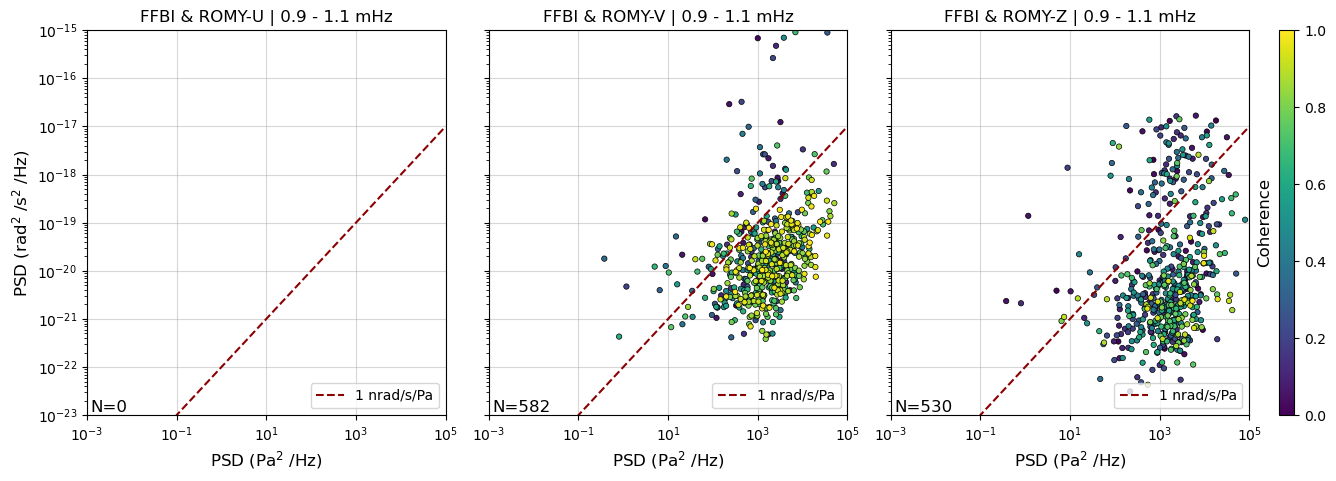

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & ROMY-U | 1.1 - 1.4 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-V | 1.1 - 1.4 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-Z | 1.1 - 1.4 mHz')

Text(0.01, 0.04, 'N=0')

Text(0.01, 0.04, 'N=0')

Text(0.01, 0.04, 'N=0')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

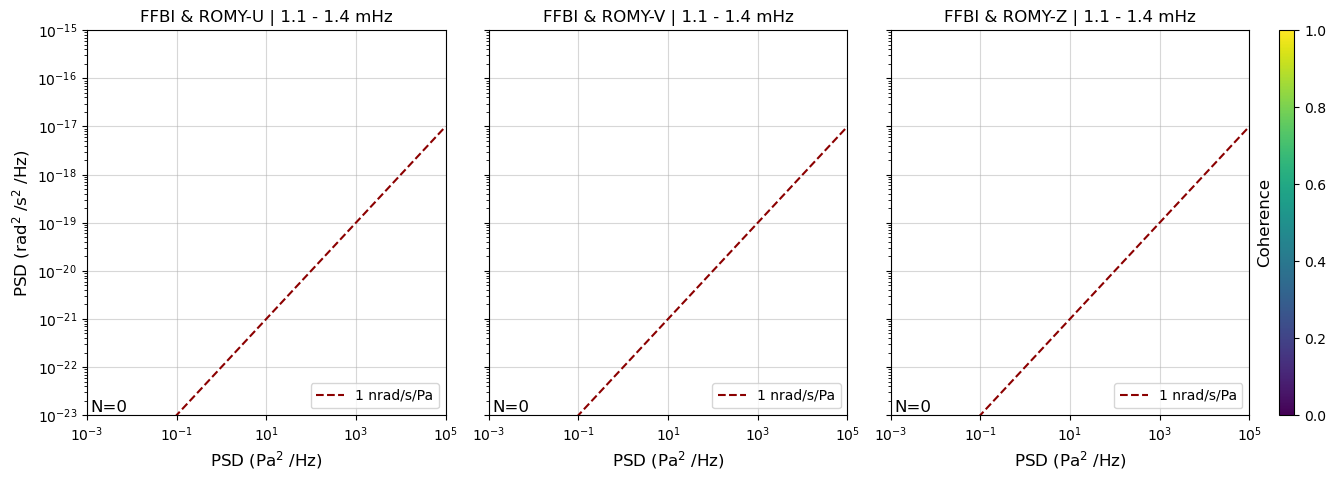

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & ROMY-U | 1.4 - 1.8 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-V | 1.4 - 1.8 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-Z | 1.4 - 1.8 mHz')

Text(0.01, 0.04, 'N=170')

Text(0.01, 0.04, 'N=581')

Text(0.01, 0.04, 'N=530')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

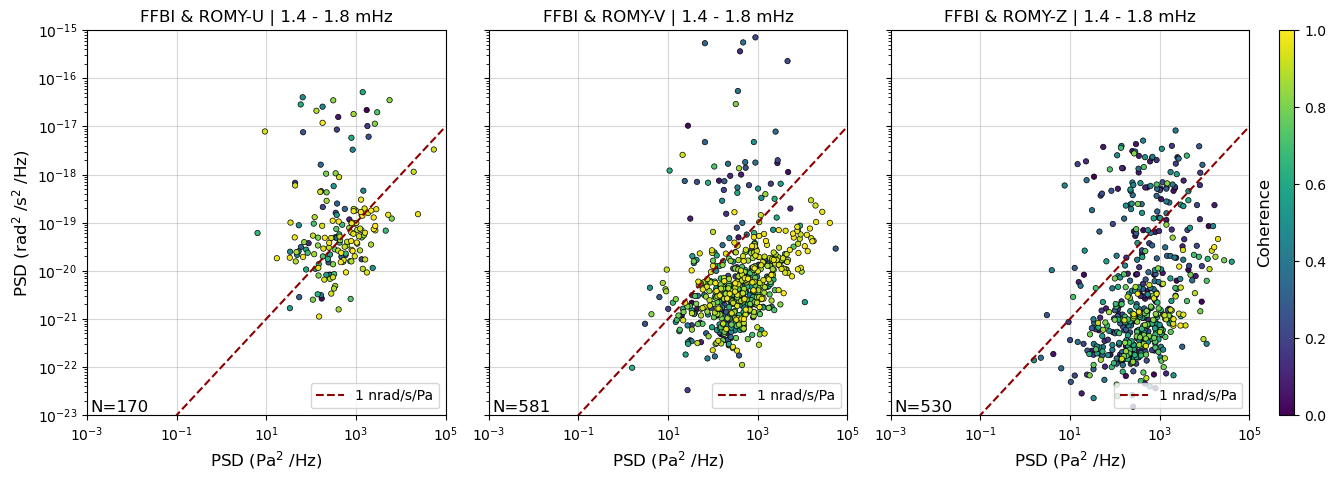

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & ROMY-U | 1.8 - 2.2 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-V | 1.8 - 2.2 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-Z | 1.8 - 2.2 mHz')

Text(0.01, 0.04, 'N=171')

Text(0.01, 0.04, 'N=581')

Text(0.01, 0.04, 'N=530')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

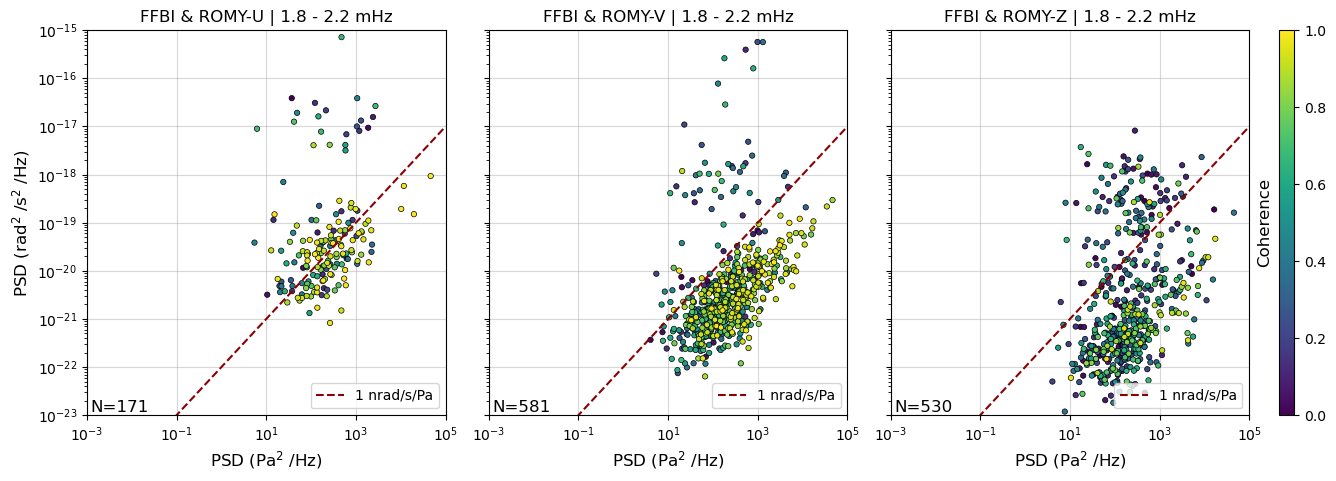

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & ROMY-U | 2.2 - 2.8 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-V | 2.2 - 2.8 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-Z | 2.2 - 2.8 mHz')

Text(0.01, 0.04, 'N=170')

Text(0.01, 0.04, 'N=584')

Text(0.01, 0.04, 'N=530')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

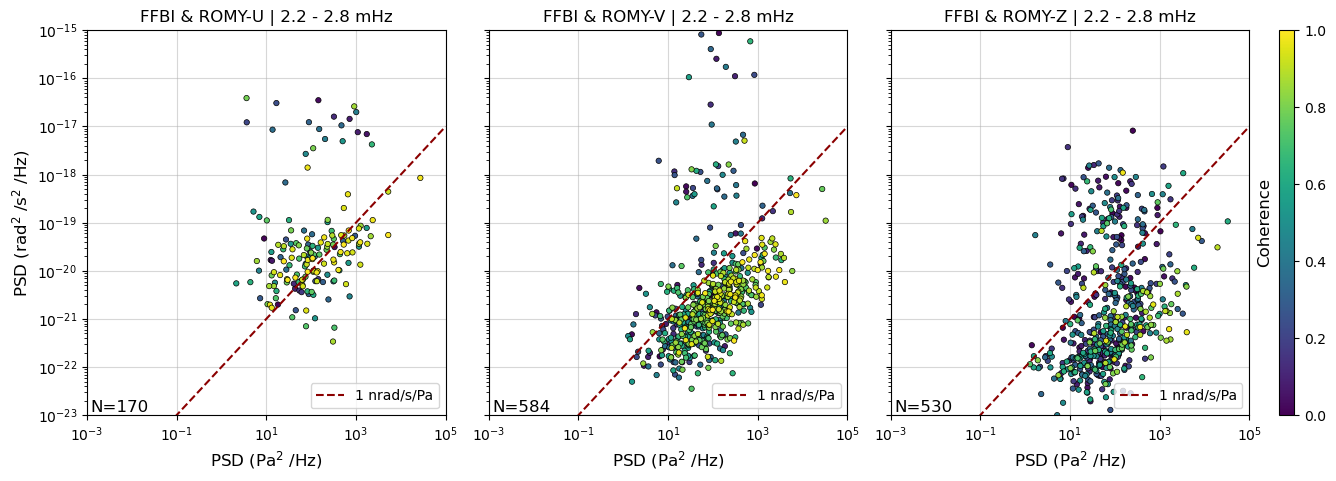

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & ROMY-U | 2.8 - 3.5 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-V | 2.8 - 3.5 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-Z | 2.8 - 3.5 mHz')

Text(0.01, 0.04, 'N=170')

Text(0.01, 0.04, 'N=586')

Text(0.01, 0.04, 'N=530')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

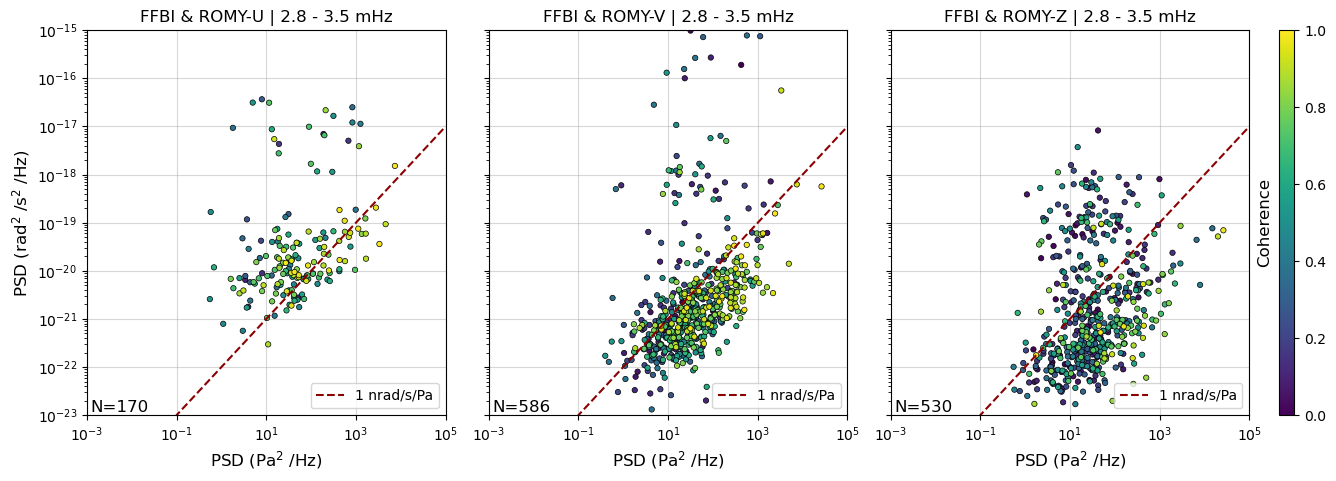

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & ROMY-U | 3.6 - 4.5 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-V | 3.6 - 4.5 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-Z | 3.6 - 4.5 mHz')

Text(0.01, 0.04, 'N=170')

Text(0.01, 0.04, 'N=588')

Text(0.01, 0.04, 'N=530')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

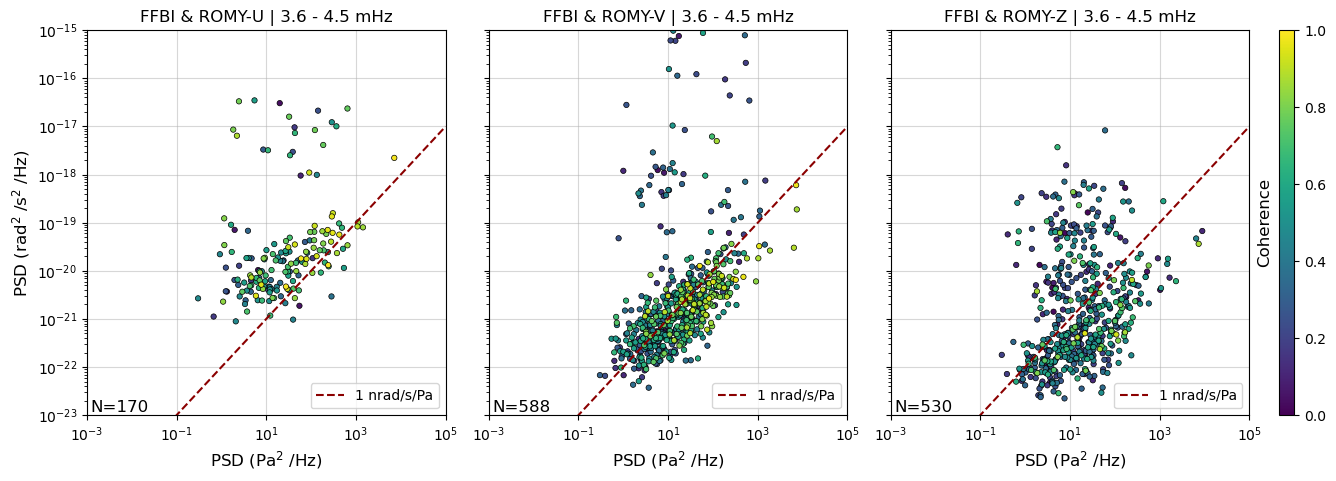

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & ROMY-U | 4.5 - 5.6 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-V | 4.5 - 5.6 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-Z | 4.5 - 5.6 mHz')

Text(0.01, 0.04, 'N=171')

Text(0.01, 0.04, 'N=588')

Text(0.01, 0.04, 'N=531')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

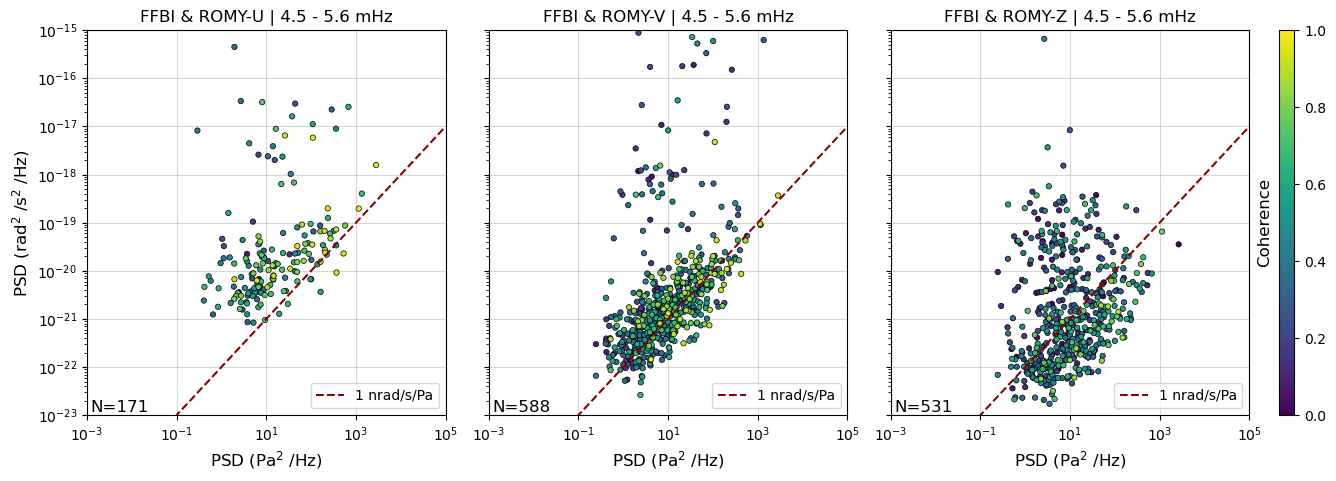

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & ROMY-U | 5.6 - 7.1 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-V | 5.6 - 7.1 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-Z | 5.6 - 7.1 mHz')

Text(0.01, 0.04, 'N=171')

Text(0.01, 0.04, 'N=595')

Text(0.01, 0.04, 'N=531')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

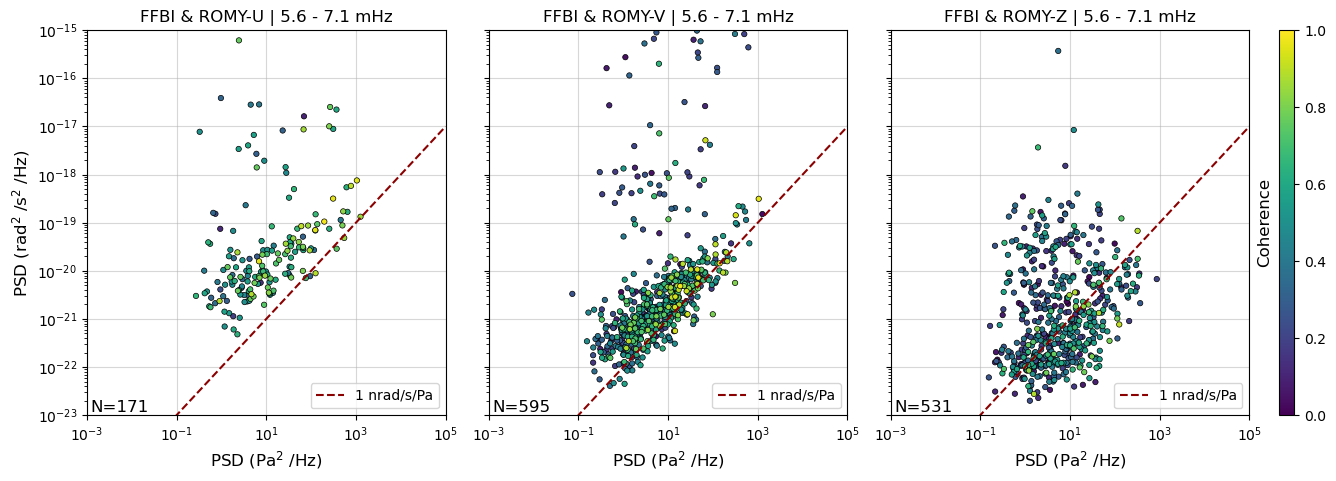

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & ROMY-U | 7.1 - 9.0 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-V | 7.1 - 9.0 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-Z | 7.1 - 9.0 mHz')

Text(0.01, 0.04, 'N=170')

Text(0.01, 0.04, 'N=594')

Text(0.01, 0.04, 'N=533')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

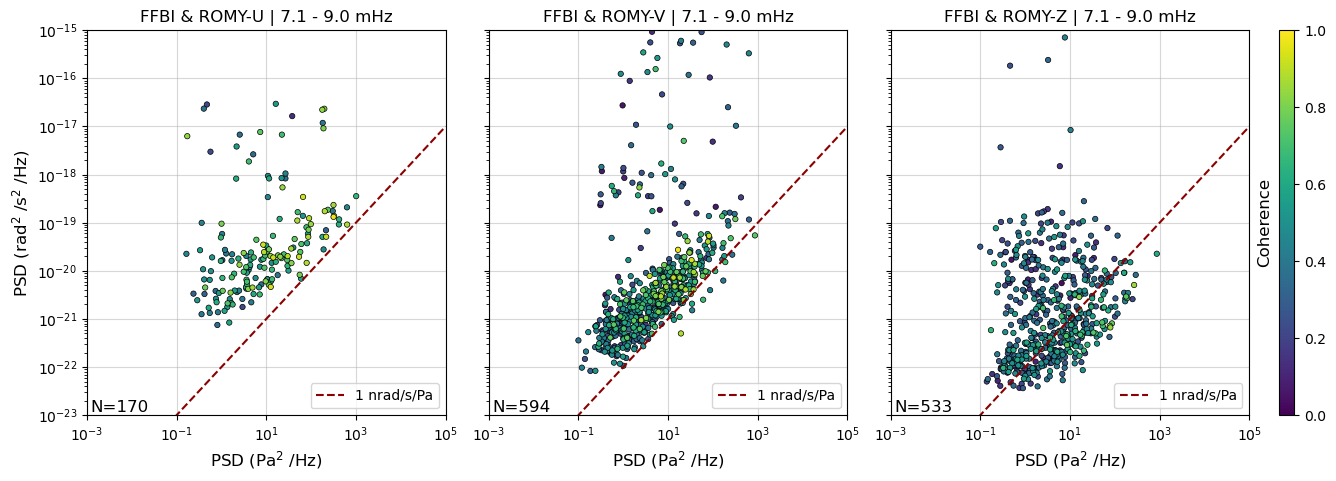

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & ROMY-U | 8.9 - 11.2 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-V | 8.9 - 11.2 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-Z | 8.9 - 11.2 mHz')

Text(0.01, 0.04, 'N=170')

Text(0.01, 0.04, 'N=593')

Text(0.01, 0.04, 'N=531')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

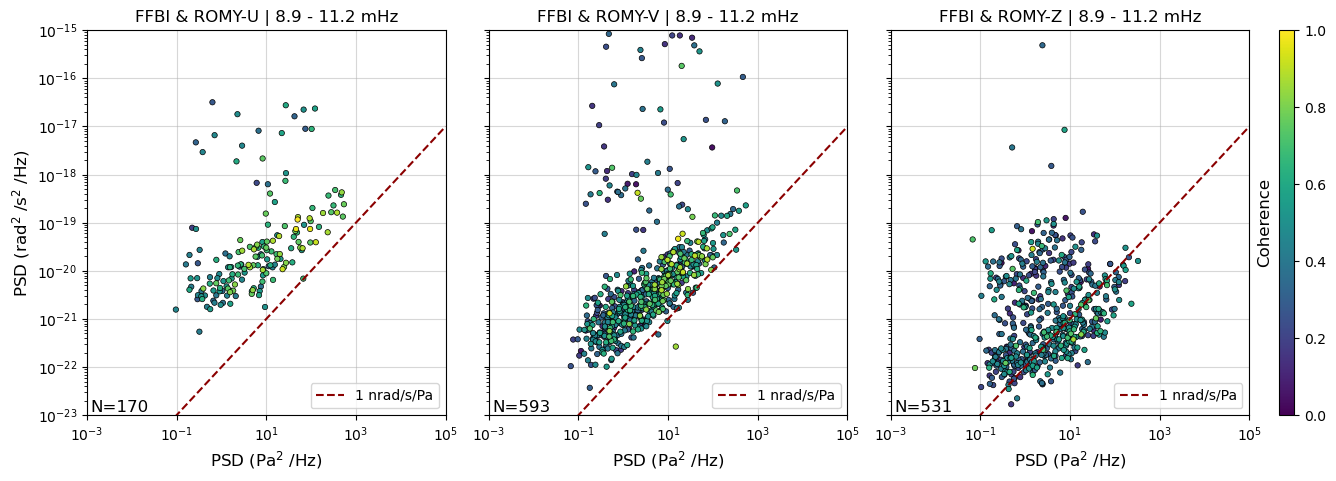

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & ROMY-U | 11.1 - 14.0 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-V | 11.1 - 14.0 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-Z | 11.1 - 14.0 mHz')

Text(0.01, 0.04, 'N=170')

Text(0.01, 0.04, 'N=601')

Text(0.01, 0.04, 'N=531')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

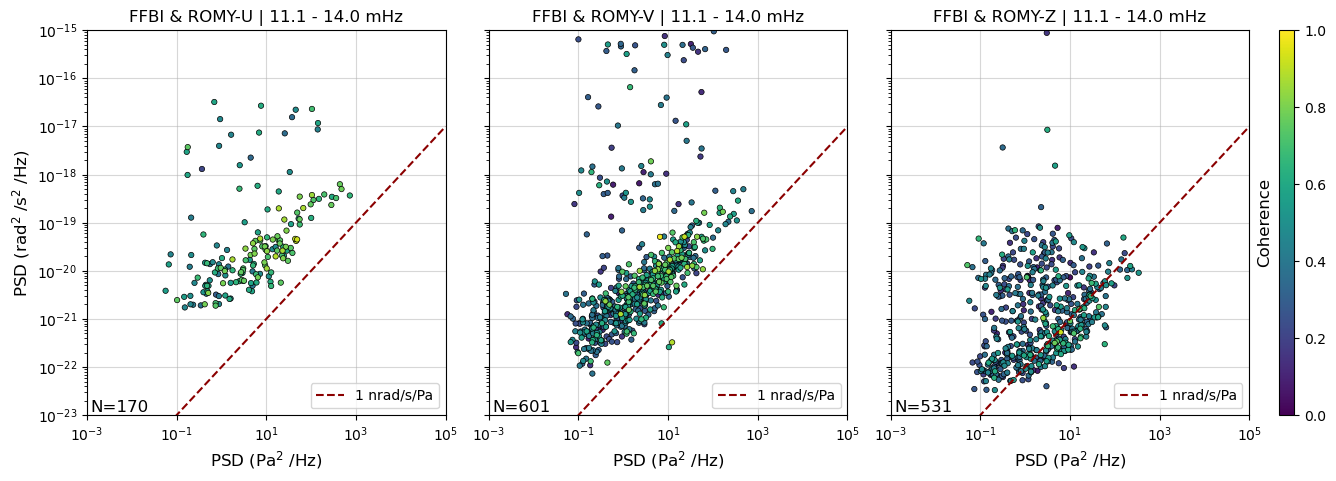

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & ROMY-U | 14.3 - 18.0 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-V | 14.3 - 18.0 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-Z | 14.3 - 18.0 mHz')

Text(0.01, 0.04, 'N=172')

Text(0.01, 0.04, 'N=611')

Text(0.01, 0.04, 'N=532')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

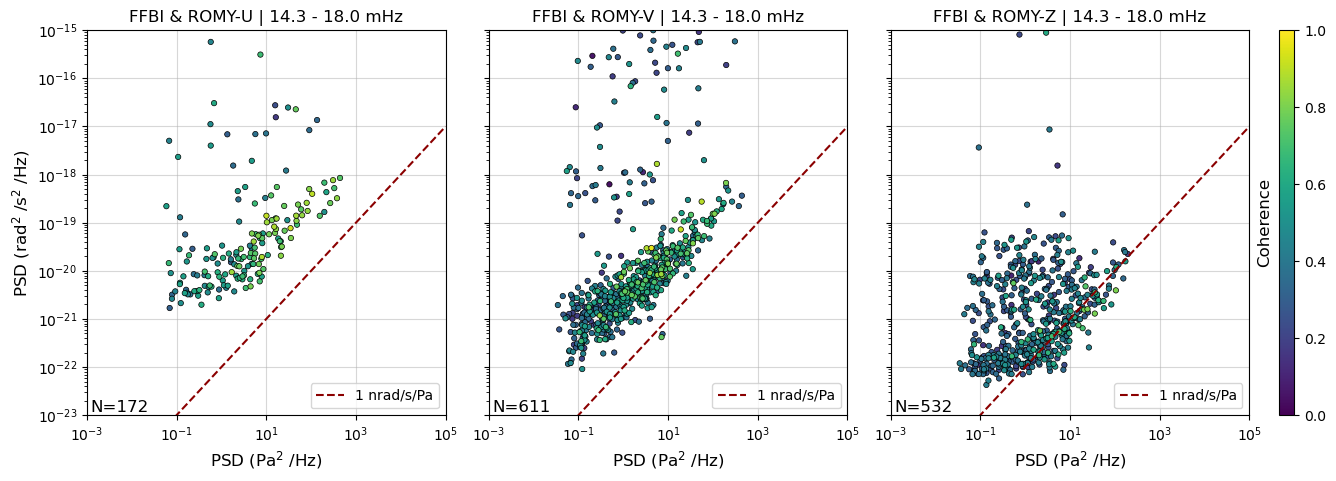

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & ROMY-U | 17.8 - 22.4 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-V | 17.8 - 22.4 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-Z | 17.8 - 22.4 mHz')

Text(0.01, 0.04, 'N=172')

Text(0.01, 0.04, 'N=616')

Text(0.01, 0.04, 'N=532')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

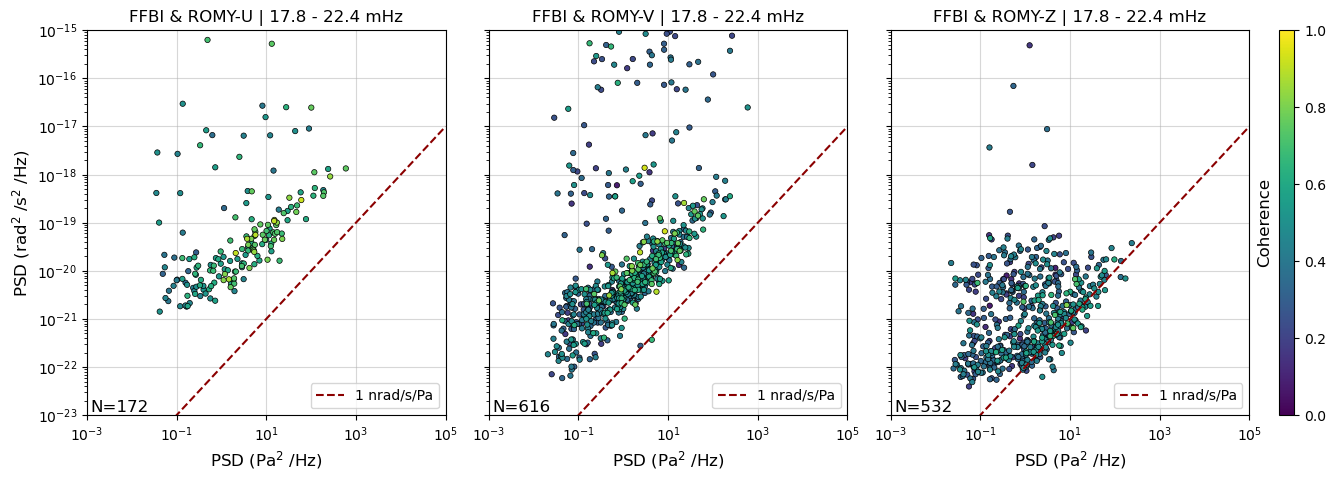

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & ROMY-U | 22.3 - 28.1 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-V | 22.3 - 28.1 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-Z | 22.3 - 28.1 mHz')

Text(0.01, 0.04, 'N=171')

Text(0.01, 0.04, 'N=616')

Text(0.01, 0.04, 'N=532')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

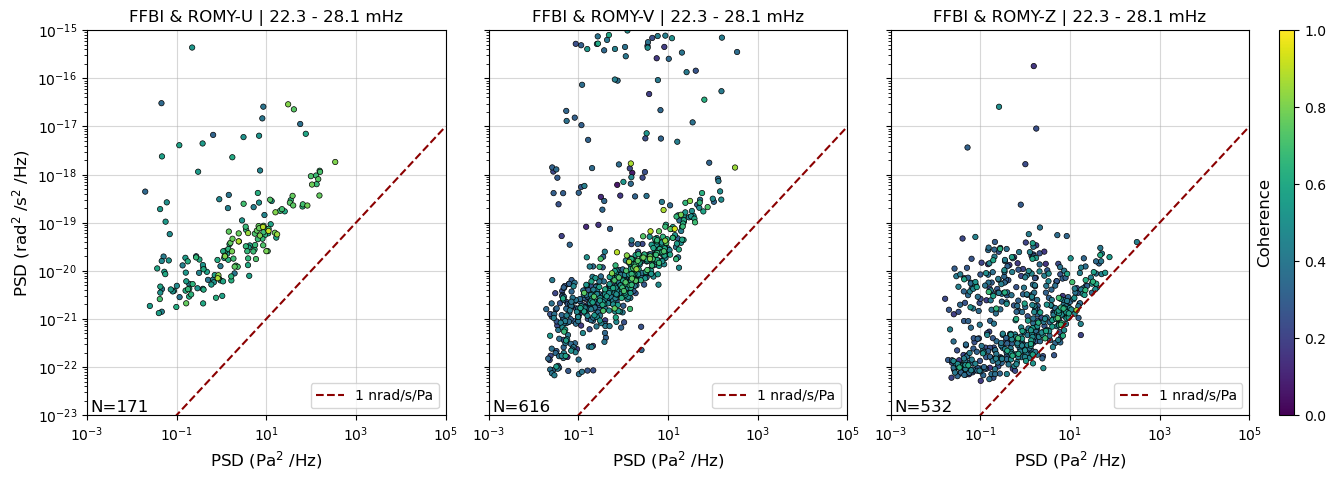

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & ROMY-U | 28.1 - 35.4 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-V | 28.1 - 35.4 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-Z | 28.1 - 35.4 mHz')

Text(0.01, 0.04, 'N=171')

Text(0.01, 0.04, 'N=615')

Text(0.01, 0.04, 'N=532')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

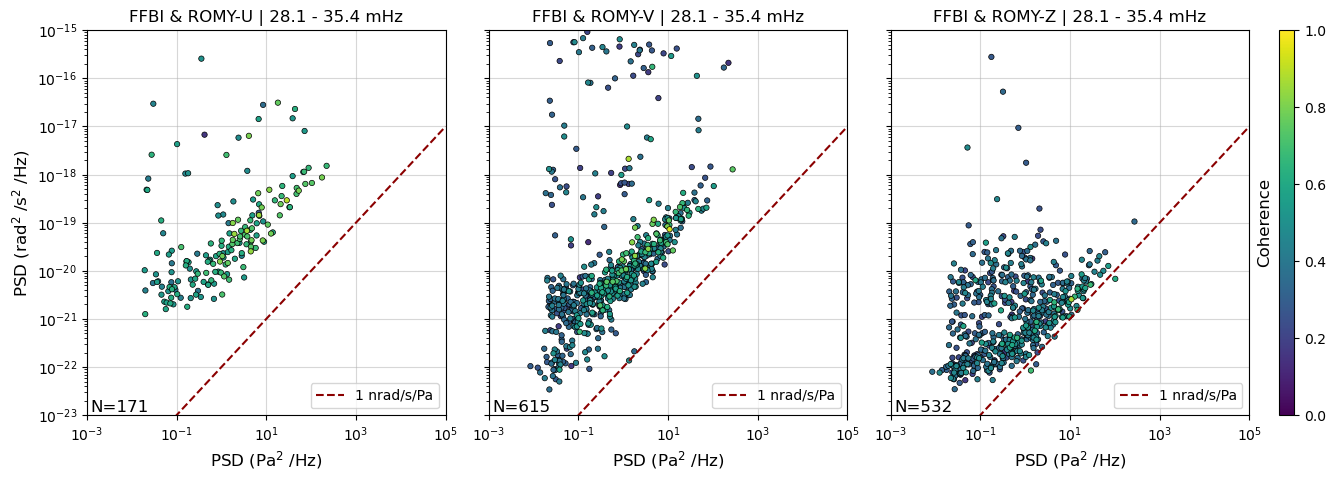

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & ROMY-U | 35.6 - 44.9 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-V | 35.6 - 44.9 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-Z | 35.6 - 44.9 mHz')

Text(0.01, 0.04, 'N=172')

Text(0.01, 0.04, 'N=617')

Text(0.01, 0.04, 'N=533')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

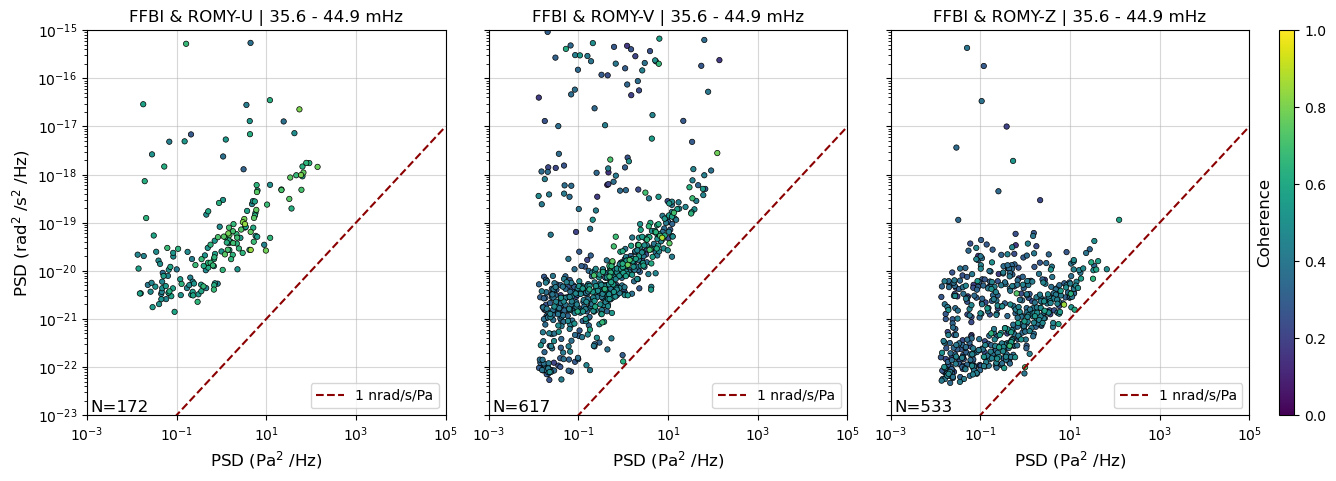

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & ROMY-U | 44.5 - 56.1 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-V | 44.5 - 56.1 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-Z | 44.5 - 56.1 mHz')

Text(0.01, 0.04, 'N=171')

Text(0.01, 0.04, 'N=616')

Text(0.01, 0.04, 'N=532')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

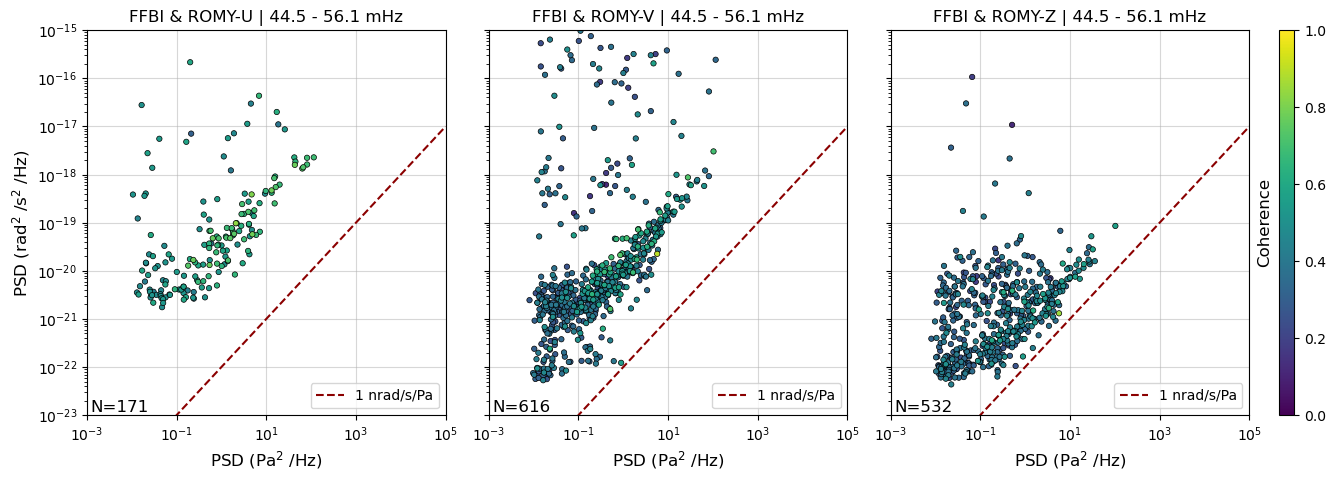

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & ROMY-U | 56.1 - 70.7 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-V | 56.1 - 70.7 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-Z | 56.1 - 70.7 mHz')

Text(0.01, 0.04, 'N=171')

Text(0.01, 0.04, 'N=617')

Text(0.01, 0.04, 'N=533')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

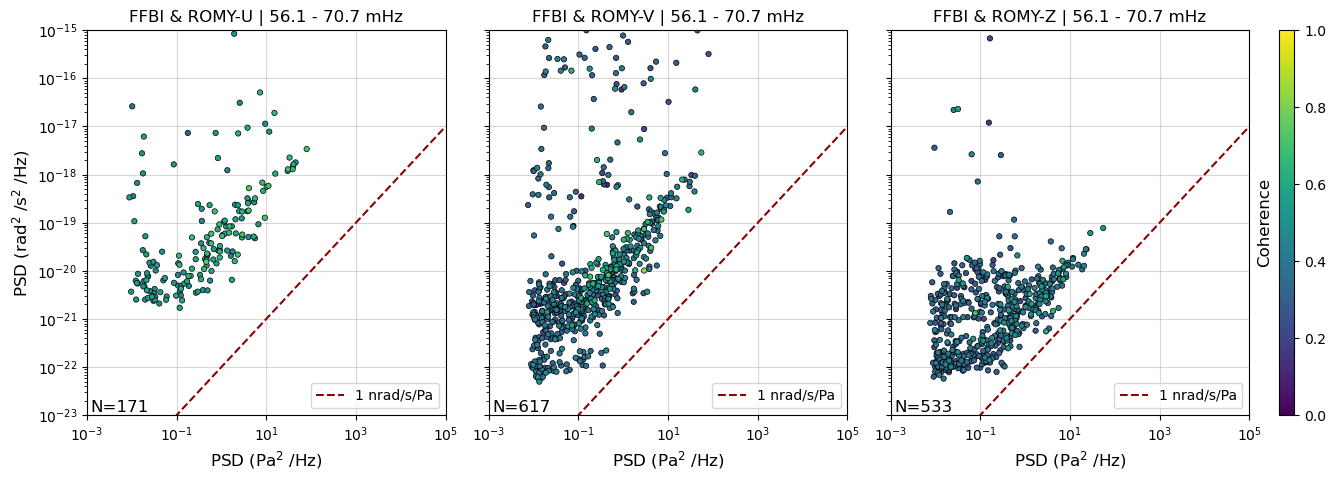

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & ROMY-U | 71.3 - 89.8 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-V | 71.3 - 89.8 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-Z | 71.3 - 89.8 mHz')

Text(0.01, 0.04, 'N=171')

Text(0.01, 0.04, 'N=618')

Text(0.01, 0.04, 'N=533')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

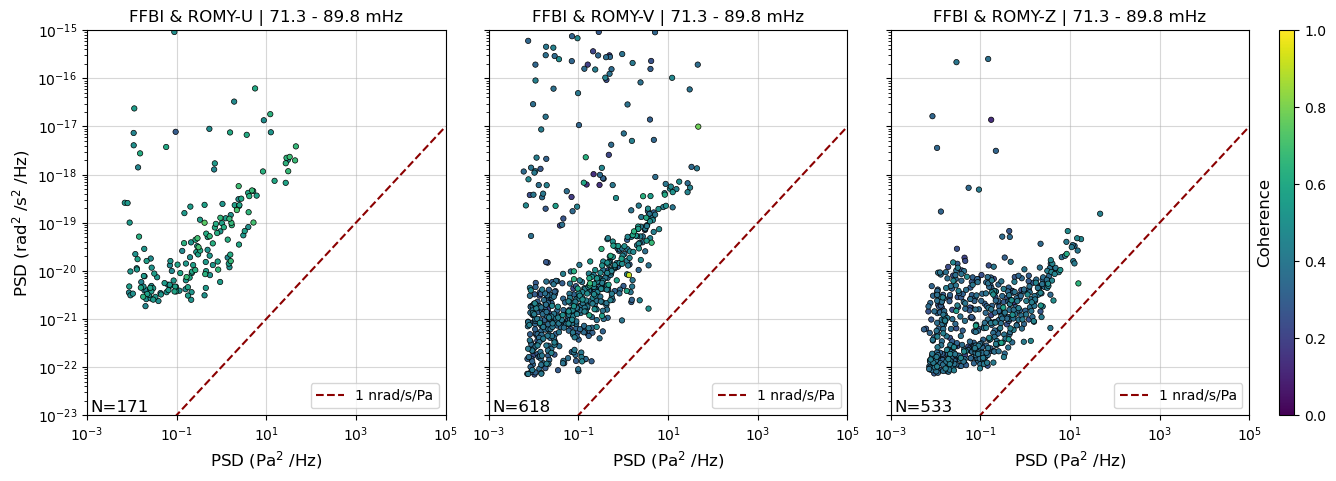

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & ROMY-U | 89.1 - 112.2 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-V | 89.1 - 112.2 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-Z | 89.1 - 112.2 mHz')

Text(0.01, 0.04, 'N=171')

Text(0.01, 0.04, 'N=617')

Text(0.01, 0.04, 'N=532')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

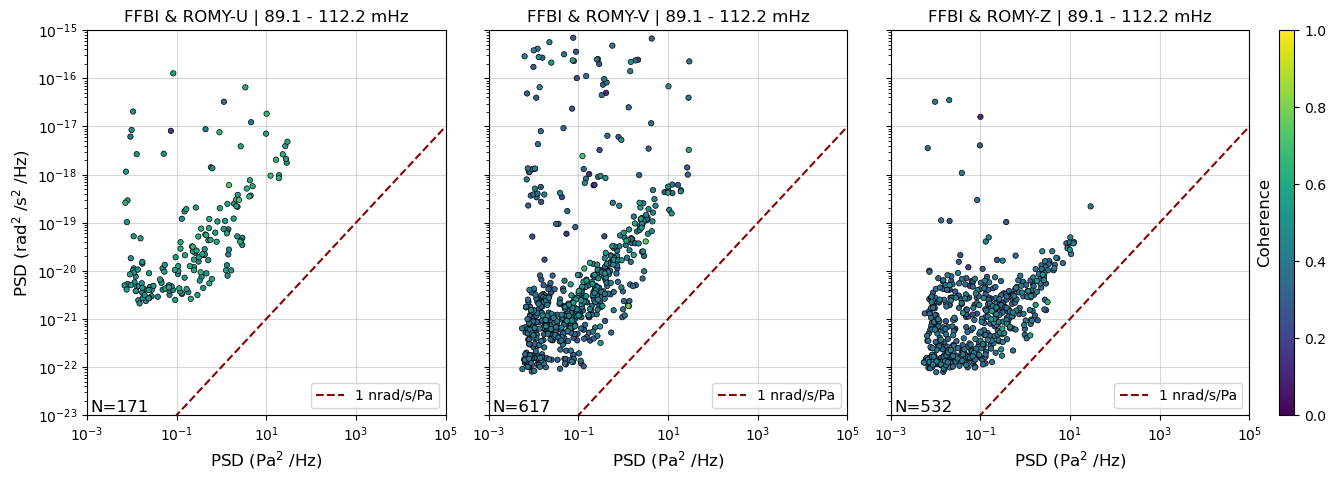

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & ROMY-U | 111.4 - 140.3 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-V | 111.4 - 140.3 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-Z | 111.4 - 140.3 mHz')

Text(0.01, 0.04, 'N=171')

Text(0.01, 0.04, 'N=617')

Text(0.01, 0.04, 'N=533')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

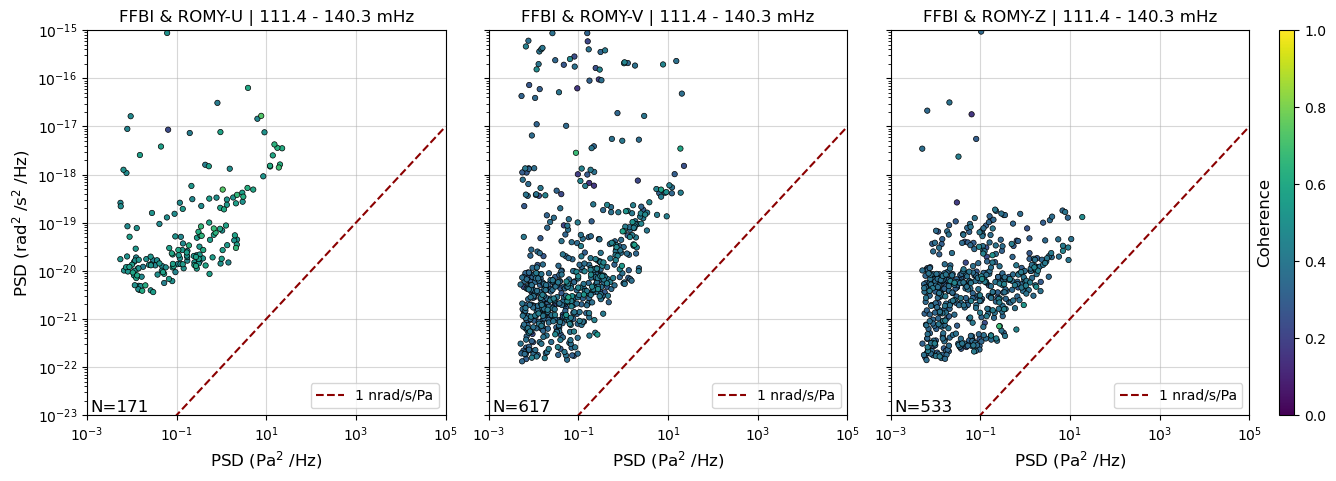

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & ROMY-U | 142.5 - 179.6 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-V | 142.5 - 179.6 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-Z | 142.5 - 179.6 mHz')

Text(0.01, 0.04, 'N=172')

Text(0.01, 0.04, 'N=616')

Text(0.01, 0.04, 'N=533')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

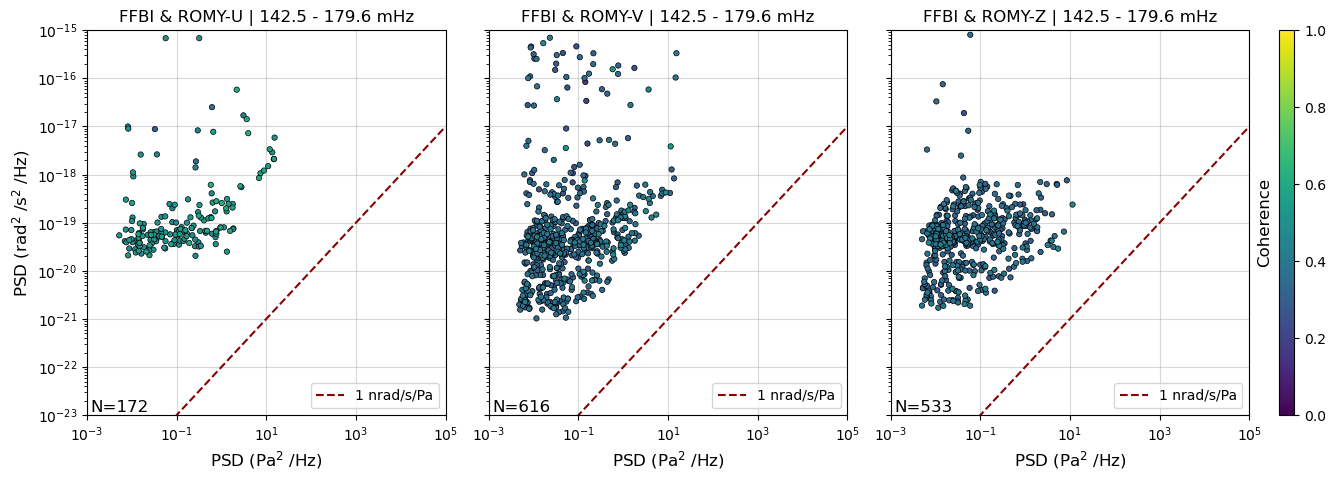

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & ROMY-U | 178.2 - 224.5 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-V | 178.2 - 224.5 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-Z | 178.2 - 224.5 mHz')

Text(0.01, 0.04, 'N=172')

Text(0.01, 0.04, 'N=616')

Text(0.01, 0.04, 'N=533')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

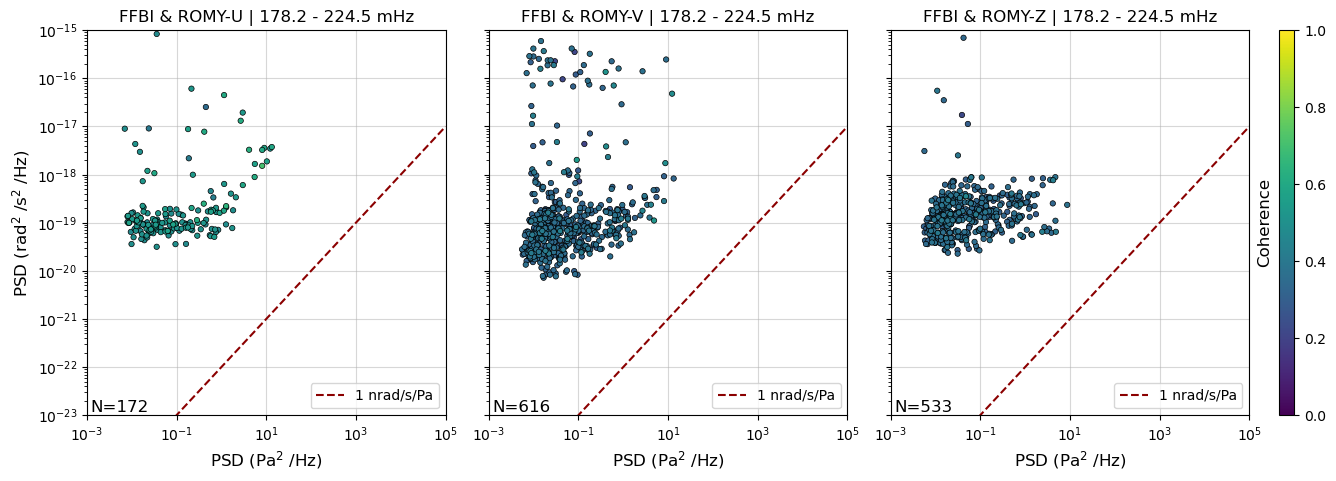

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & ROMY-U | 222.7 - 280.6 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-V | 222.7 - 280.6 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-Z | 222.7 - 280.6 mHz')

Text(0.01, 0.04, 'N=172')

Text(0.01, 0.04, 'N=617')

Text(0.01, 0.04, 'N=532')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

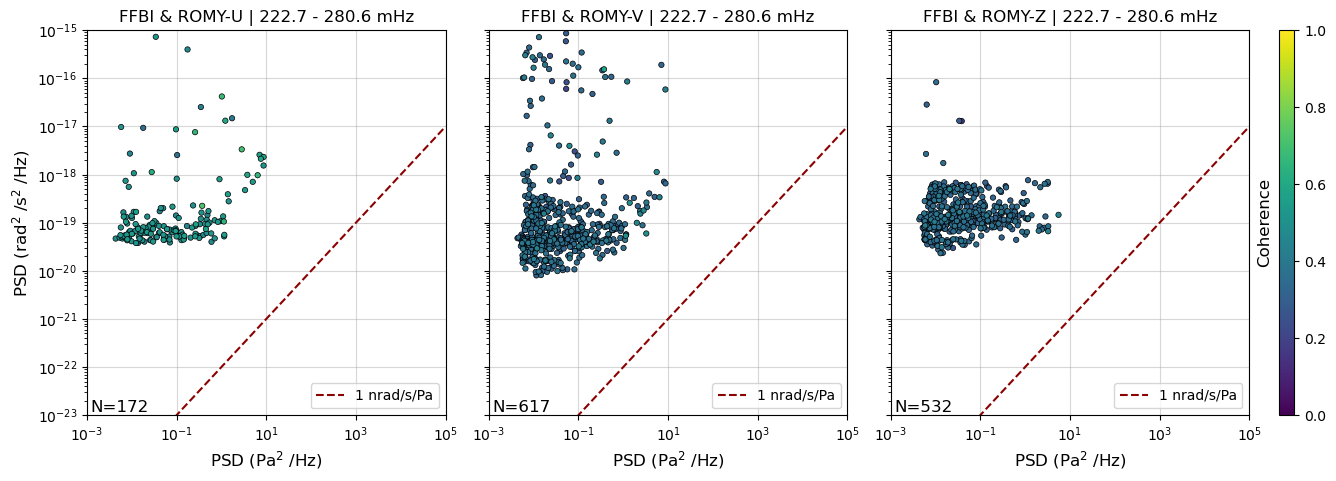

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & ROMY-U | 280.6 - 353.6 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-V | 280.6 - 353.6 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-Z | 280.6 - 353.6 mHz')

Text(0.01, 0.04, 'N=172')

Text(0.01, 0.04, 'N=618')

Text(0.01, 0.04, 'N=533')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

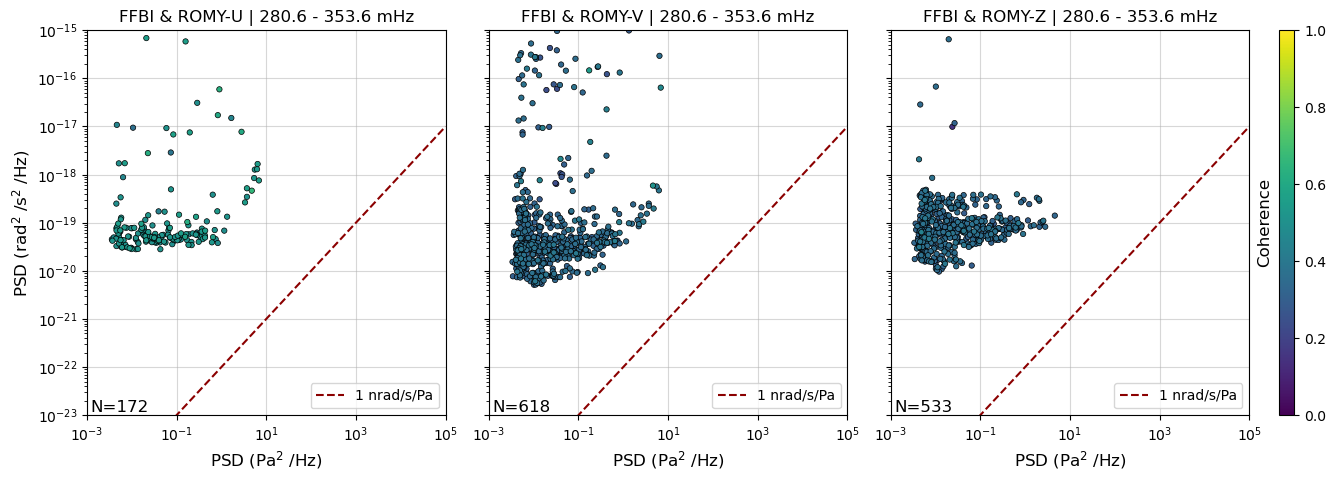

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & ROMY-U | 356.4 - 449.0 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-V | 356.4 - 449.0 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-Z | 356.4 - 449.0 mHz')

Text(0.01, 0.04, 'N=172')

Text(0.01, 0.04, 'N=617')

Text(0.01, 0.04, 'N=532')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

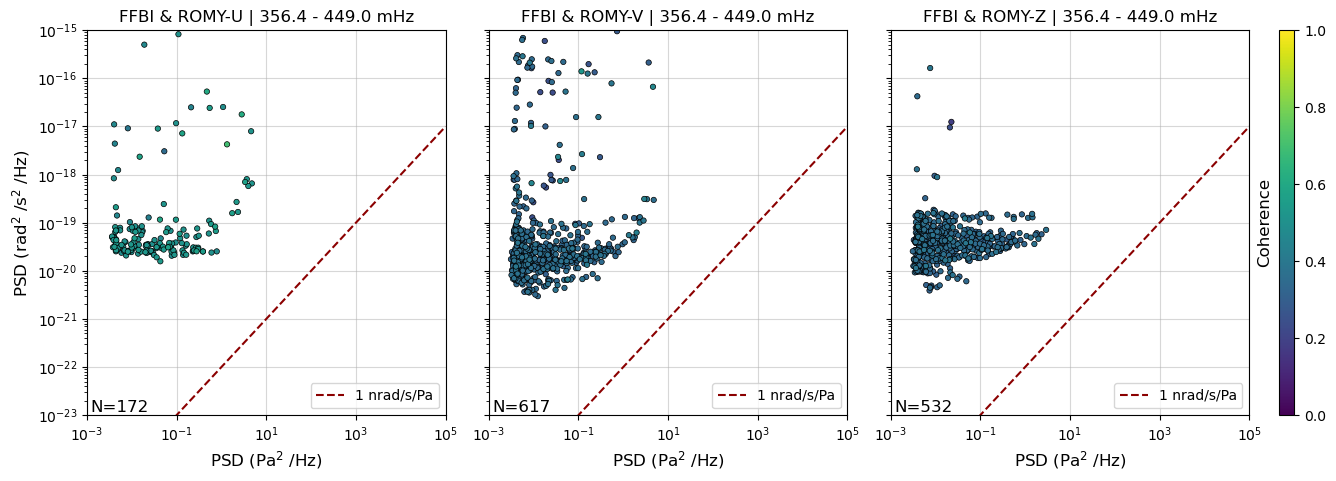

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & ROMY-U | 445.4 - 561.2 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-V | 445.4 - 561.2 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-Z | 445.4 - 561.2 mHz')

Text(0.01, 0.04, 'N=171')

Text(0.01, 0.04, 'N=618')

Text(0.01, 0.04, 'N=532')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

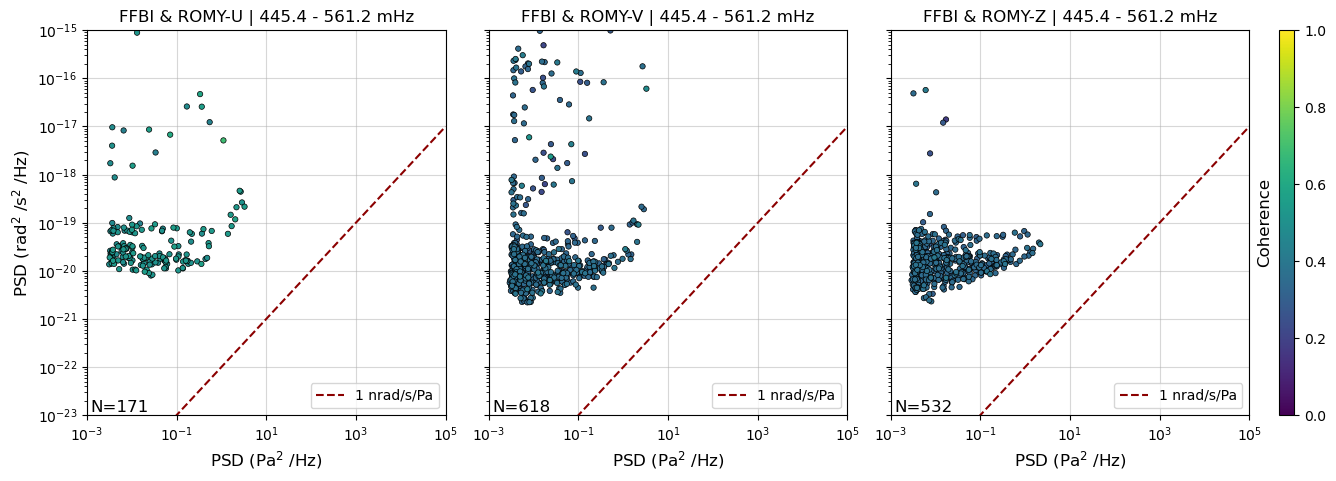

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & ROMY-U | 561.3 - 707.2 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-V | 561.3 - 707.2 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-Z | 561.3 - 707.2 mHz')

Text(0.01, 0.04, 'N=172')

Text(0.01, 0.04, 'N=618')

Text(0.01, 0.04, 'N=532')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

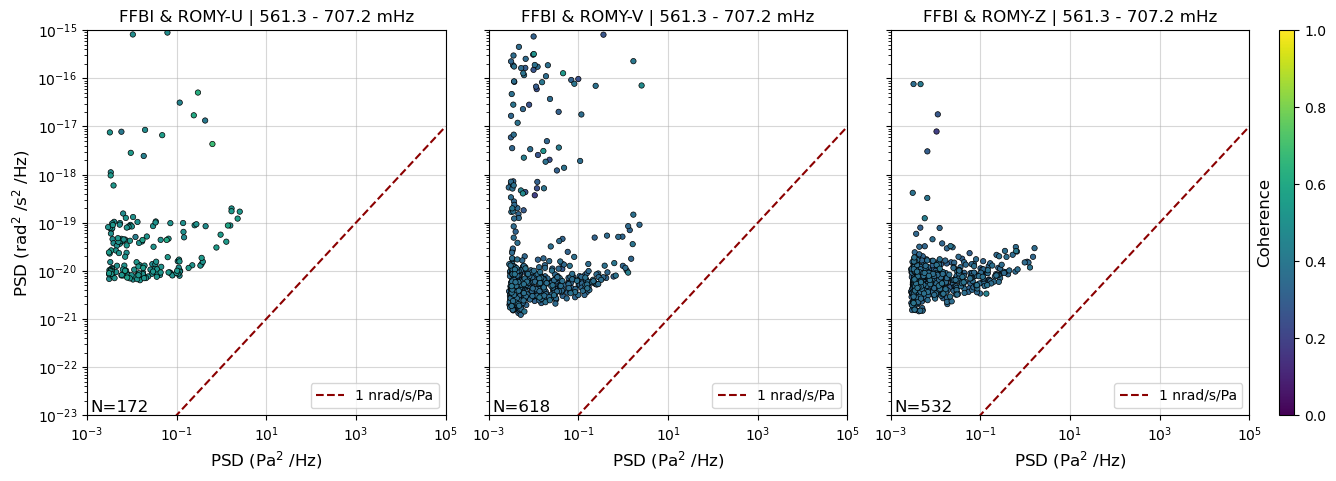

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & ROMY-U | 712.7 - 898.0 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-V | 712.7 - 898.0 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-Z | 712.7 - 898.0 mHz')

Text(0.01, 0.04, 'N=171')

Text(0.01, 0.04, 'N=620')

Text(0.01, 0.04, 'N=532')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

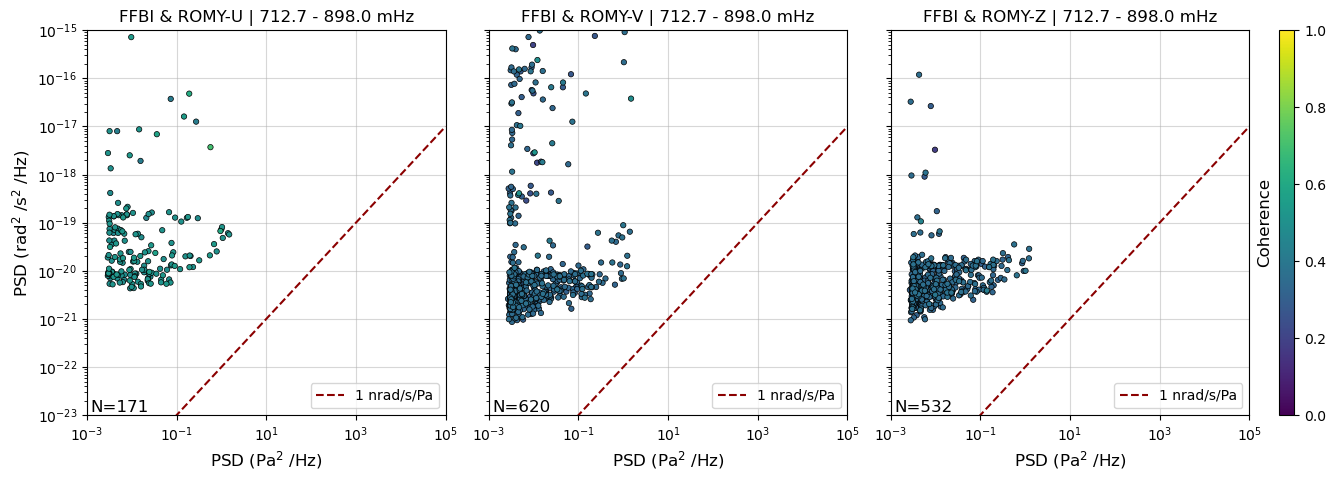

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

(0.001, 100000.0)

(1e-23, 1e-15)

Text(0.5, 0, 'PSD (Pa$^2$ /Hz)')

Text(0.5, 1.0, 'FFBI & ROMY-U | 890.9 - 1122.5 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-V | 890.9 - 1122.5 mHz')

Text(0.5, 1.0, 'FFBI & ROMY-Z | 890.9 - 1122.5 mHz')

Text(0.01, 0.04, 'N=171')

Text(0.01, 0.04, 'N=620')

Text(0.01, 0.04, 'N=533')

Text(0, 0.5, 'PSD (rad$^2$ /s$^2$ /Hz)')

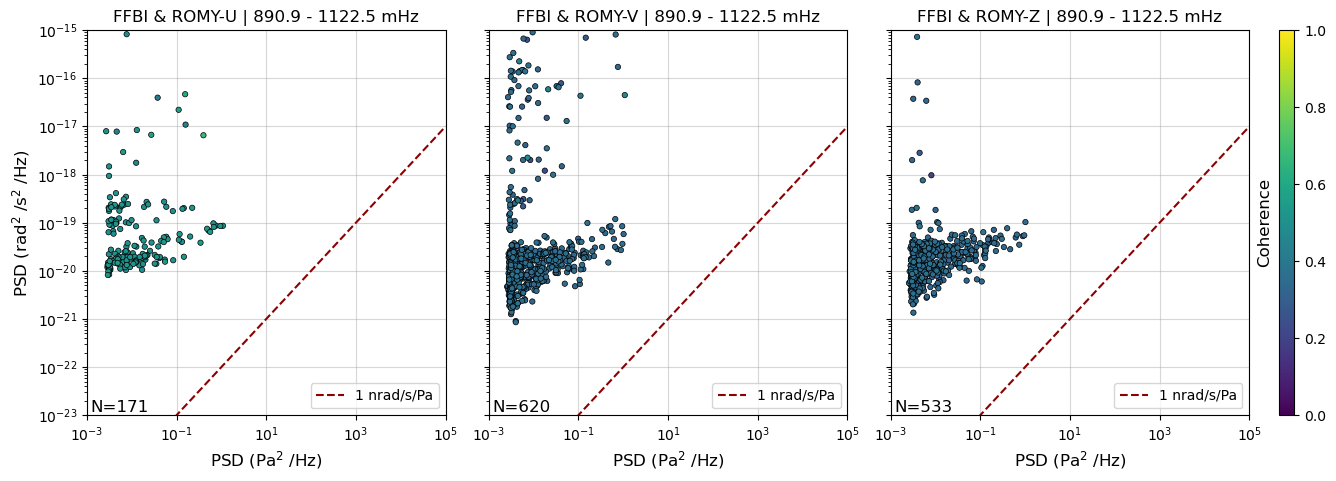

In [19]:
f_lower, f_upper, f_center = __get_octave_bands(1e-3, 1e0, fband_type="one-third-octave", plot=False)

N_bands = dat0.shape[1] - 1

bands = dat0.keys()[1:]

for _n, band in enumerate(bands):

    # if not _n == 13:
    #     continue

    _dat0 = dat0.loc[:, ["dates", band]]
    _dat1 = dat1.loc[:, ["dates", band]]
    _dat2 = dat2.loc[:, ["dates", band]]
    _dat3 = dat3.loc[:, ["dates", band]]

    _coh1 = coh1.loc[:, ["dates", band]]
    _coh2 = coh2.loc[:, ["dates", band]]
    _coh3 = coh3.loc[:, ["dates", band]]

    ## join data frames based on dates and hour
    _df1 = pd.merge(left=_dat0, right=_dat1, how="inner", on="dates")
    _df2 = pd.merge(left=_dat0, right=_dat2, how="inner", on="dates")
    _df3 = pd.merge(left=_dat0, right=_dat3, how="inner", on="dates")

    _df1 = pd.merge(left=_df1, right=_coh1, how="inner", on="dates")
    _df2 = pd.merge(left=_df2, right=_coh2, how="inner", on="dates")
    _df3 = pd.merge(left=_df3, right=_coh3, how="inner", on="dates")

    # ## remove NaN values
    _df1.dropna(inplace=True)
    _df2.dropna(inplace=True)
    _df3.dropna(inplace=True)

    ## remove large values
    _df1 = _df1[_df1.iloc[:, 2] < 1e-15]
    _df2 = _df2[_df2.iloc[:, 2] < 1e-15]
    _df3 = _df3[_df3.iloc[:, 2] < 1e-15]

    ## reset the index
    _df1 = _df1.reset_index(drop=True)
    _df2 = _df2.reset_index(drop=True)
    _df3 = _df3.reset_index(drop=True)

    _df1 = _df1.sort_values(by=band, ascending=True)
    _df2 = _df2.sort_values(by=band, ascending=True)
    _df3 = _df3.sort_values(by=band, ascending=True)

    xx1, yy1, ccoh1 = np.log10(_df1.iloc[:, 1]), np.log10(_df1.iloc[:, 2]), _df1.iloc[:, 3]
    xx2, yy2, ccoh2 = np.log10(_df2.iloc[:, 1]), np.log10(_df2.iloc[:, 2]), _df2.iloc[:, 3]
    xx3, yy3, ccoh3 = np.log10(_df3.iloc[:, 1]), np.log10(_df3.iloc[:, 2]), _df3.iloc[:, 3]

#     try:
#         pre1 = __quantile_regression(xx1, yy1, quantiles=[0.01, 0.5, 0.99])
#         pre2 = __quantile_regression(xx2, yy2, quantiles=[0.01, 0.5, 0.99])
#         pre3 = __quantile_regression(xx3, yy3, quantiles=[0.01, 0.5, 0.99])

#     except Exception as e:
#         print(e)
#         pass


    fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

    font = 12

    cmap = plt.colormaps.get("viridis")

    plt.subplots_adjust(wspace=0.12)

    # ca1 = ax[0].scatter(10**xx1, 10**yy1, s=15, c=ccoh1, alpha=ccoh1, edgecolors="black", lw=0.5, zorder=2, cmap=cmap, vmin=0, vmax=1)
    # ca2 = ax[1].scatter(10**xx2, 10**yy2, s=15, c=ccoh2, alpha=ccoh2, edgecolors="black", lw=0.5, zorder=2, cmap=cmap, vmin=0, vmax=1)
    # ca3 = ax[2].scatter(10**xx3, 10**yy3, s=15, c=ccoh3, alpha=ccoh3, edgecolors="black", lw=0.5, zorder=2, cmap=cmap, vmin=0, vmax=1)
    ca1 = ax[0].scatter(10**xx1, 10**yy1, s=15, c=ccoh1, edgecolors="black", lw=0.5, zorder=2, cmap=cmap, vmin=0, vmax=1)
    ca2 = ax[1].scatter(10**xx2, 10**yy2, s=15, c=ccoh2, edgecolors="black", lw=0.5, zorder=2, cmap=cmap, vmin=0, vmax=1)
    ca3 = ax[2].scatter(10**xx3, 10**yy3, s=15, c=ccoh3, edgecolors="black", lw=0.5, zorder=2, cmap=cmap, vmin=0, vmax=1)

#     try:

#         ax[0].plot(10**xx1, 10**pre1[0.01], color="k", zorder=1, ls=":", label="90%-fit")
#         ax[1].plot(10**xx2, 10**pre2[0.01], color="k", zorder=1, ls=":", label="90%-fit")
#         ax[2].plot(10**xx3, 10**pre3[0.01], color="k", zorder=1, ls=":", label="90%-fit")

#     except Exception as e:
#         print(e)
#         pass

    ## add correlation estimate
    _xx = np.logspace(-5, 5)
    _yy = 1e-22 * _xx
    # print(_xx, _yy)

    for _i in range(3):
        ax[_i].plot(_xx, _yy, color="darkred", ls="--", label="1 nrad/s/Pa")

    for _i in range(3):
        ax[_i].set_xscale("log")
        ax[_i].set_yscale("log")
        ax[_i].set_xlim(1e-3, 1e5)
        ax[_i].set_ylim(1e-23, 1e-15)
        ax[_i].grid(zorder=0, alpha=0.5)
        ax[_i].legend(loc=4)
        ax[_i].set_xlabel(r"PSD (Pa$^2$ /Hz)", fontsize=font)

    # ax[0].set_title(f"{name0.replace('_','-')} & {name1.replace('_','-')} | fc = {float(_df1.keys()[1][:-2])*1e3} mHz")
    # ax[1].set_title(f"{name0.replace('_','-')} & {name2.replace('_','-')} | fc = {float(_df2.keys()[1][:-2])*1e3} mHz")
    # ax[2].set_title(f"{name0.replace('_','-')} & {name3.replace('_','-')} | fc = {float(_df3.keys()[1][:-2])*1e3} mHz")
    ax[0].set_title(f"{name0.replace('_','-')} & {name1.replace('_','-')} | {round(f_lower[_n]*1e3, 1)} - {round(f_upper[_n]*1e3, 1)} mHz")
    ax[1].set_title(f"{name0.replace('_','-')} & {name2.replace('_','-')} | {round(f_lower[_n]*1e3, 1)} - {round(f_upper[_n]*1e3, 1)} mHz")
    ax[2].set_title(f"{name0.replace('_','-')} & {name3.replace('_','-')} | {round(f_lower[_n]*1e3, 1)} - {round(f_upper[_n]*1e3, 1)} mHz")

    ax[0].text(.01, .04, f"N={len(xx1)}", ha='left', va='top', transform=ax[0].transAxes, fontsize=font)
    ax[1].text(.01, .04, f"N={len(xx2)}", ha='left', va='top', transform=ax[1].transAxes, fontsize=font)
    ax[2].text(.01, .04, f"N={len(xx3)}", ha='left', va='top', transform=ax[2].transAxes, fontsize=font)

    ax[0].set_ylabel(r"PSD (rad$^2$ /s$^2$ /Hz)", fontsize=font)

    ## add colorbar
    cbar_ax = fig.add_axes([0.92, 0.11, 0.01, 0.77]) #[left, bottom, width, height]
    cb = plt.colorbar(ca1, cax=cbar_ax)
    cb.set_label("Coherence", fontsize=font, labelpad=-50, color="black")

    plt.show();

    fig.savefig(config['path_to_figs']+f"all/{str(_n).rjust(3, '0')}_{name1}_{name2}_{band}Hz_all.png", format="png", dpi=200, bbox_inches='tight');